### 1D Burger's equation

$u_t + V uu_{x} - \nu u_{xx}, x\in[-1, 1], t\in[0, 1]$

$u(0, x) = -\sin(\pi x),$

$u(t, -1)=u(t, 1)=0$

**The aim is to making use of random observation of $u$ to invert the values of $V$ and $\nu$**

In [1]:
import sys
sys.path.append('../')
sys.path.append('../py-pde/')

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
from copy import deepcopy

from utils import *
from models import *

### Solve PDE with finite difference using py-pde 

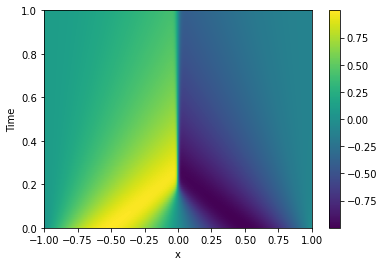

In [2]:
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph, ExplicitSolver

class Burger1D(PDEBase):
    def __init__(self, bc, V, nu):
        super(Burger1D, self).__init__()
        self.bc = bc
        self.nu = nu
        self.V = V
    def evolution_rate(self, u, t=0):
        assert u.grid.dim == 1
        u_x = u.gradient("natural")[0]
        return -self.V*u*u_x+self.nu*u.laplace("natural")
    
Nx = 1000
grid = CartesianGrid([[-1, 1]], [Nx], periodic=False)
u = ScalarField.from_expression(grid, "-sin(pi*x)")

""" Set true value of V and nu """
V0 = 2
nu0 = 0.01
storage = MemoryStorage()
eq = Burger1D(bc={"value": 0.0}, V=V0, nu=nu0)
eq.solve(u, t_range=1, tracker=storage.tracker(0.01), dt=1e-4)

plot_kymograph(storage)

In [3]:
# reshape the output, create solution for evaluation of PINN's solution
xb = grid.axes_bounds[0]
x = np.linspace(*xb, grid.shape[0]+2)
t = np.array(storage.times)
x_mesh, t_mesh = np.meshgrid(x[1:-1], t)
sol_u = torch.from_numpy(np.concatenate(storage.data)).float().reshape(-1, 1)
sol_t = torch.from_numpy(t_mesh.reshape(-1, 1)).float()
sol_x = torch.from_numpy(x_mesh.reshape(-1, 1)).float()

Nobs = 2000
idx = torch.randint(low=0, high=sol_t.shape[0], size=(Nobs,))
obs_t = sol_t[idx, :]
obs_x = sol_x[idx, :]
obs_u = sol_u[idx, :]
obs_t.requires_grad, obs_x.requires_grad = True, True

### Define model

In [4]:
class Burger1DInverse(Burger1DNN):
    def __init__(self, V, nu, N_init, N_bc, N_pde, net, device, initial_condition=True):
        super(Burger1DInverse, self).__init__(N_init, N_bc, N_pde, net, device)
        self.V = V
        self.nu = nu
        self.initial_condition = initial_condition
        
    def pde(self, x, t):
        u = self.net(x, t)
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
        return u_t + self.V*u*u_x - self.nu*u_xx
    
    def train(self, observation, optimizer, metric, max_epochs, callbacks=[]):
        x_obs, t_obs, u_obs = observation
        while self.iteration < max_epochs:
            for callback in callbacks: callback.on_batch_begin()
            optimizer.zero_grad()

            # loss from boundary and initial condition
            mse_u = metric(self.boundary_condition(self.x_bc, self.t_bc), torch.zeros_like(self.t_bc))
            if self.initial_condition:
                mse_u += metric(self.initial_condtion(self.x_init, self.t_init), torch.zeros_like(self.t_init))        

            # loss from PDE
            mse_f = metric(self.pde(self.x_pde, self.t_pde), torch.zeros_like(self.t_pde))
            
            # loss from observation
            mse_obs = mse_loss(self.net(x_obs, t_obs), u_obs)

            loss = mse_u + mse_f + mse_obs
            
            with autograd.no_grad():
                for callback in callbacks: 
                    callback.on_loss_end(**{'training loss': loss.item(), 
                                            'V': self.V.item(), 'nu': self.nu.item()})
            # BP
            loss.backward(retain_graph=True)
            optimizer.step()
            with autograd.no_grad():
                for callback in callbacks: callback.on_step_end()
            self.iteration += 1

### Case 1: observation without noise

In [5]:
# defnitions
activation = torch.tanh
n_hidden = 5
n_nodes = 5

N_init, N_bc, N_pde = 50, 50, 5000

max_epochs = 20001
mse_loss = torch.nn.MSELoss()

In [6]:
torch.manual_seed(250)
net0 = TimeDependentFFN(activation, n_hidden, n_nodes, inputs=1).to(device)
nu = torch.rand((1,), requires_grad=True)
V = torch.rand((1,), requires_grad=True)
initial_state =deepcopy(net0.state_dict())

model0 = Burger1DInverse(V, nu, N_init, N_bc, N_pde, net0, device, 
                         initial_condition=True)
optimizer = torch.optim.Adam(list(net0.parameters()) + [V, nu])

callbacks = []
resample_period = 20
callbacks.append(ResamplingHandler(model0, sampling_rate=resample_period))
pde_errors0 = []
callbacks.append(ValueTracker(name='training loss', values=pde_errors0))
Vs0, nus0 = [],[]
callbacks.append(ValueTracker(name='V', values=Vs0))
callbacks.append(ValueTracker(name='nu', values=nus0))
u_errors0 = []
callbacks.append(ValidationErrorTracker(model0, mse_loss, 
                                        (sol_x, sol_t, sol_u), errors=u_errors0))
callbacks.append(DiagnosticVerbose(trainer=model0, print_rate=500, 
                                   values={'pde error': pde_errors0, 
                                           'solution error': u_errors0, 
                                           'V': Vs0,
                                           'nu': nus0}))

In [7]:
# train the model
model0.train((obs_x, obs_t, obs_u), optimizer, mse_loss, max_epochs, callbacks)

At epoch 0: pde error: 0.7610; solution error: 0.2418; V: 0.3723; nu: 0.3923; 
At epoch 500: pde error: 0.2391; solution error: 0.0515; V: 0.4335; nu: 0.0111; 
At epoch 1000: pde error: 0.0823; solution error: 0.0383; V: 0.4970; nu: 0.0361; 
At epoch 1500: pde error: 0.0530; solution error: 0.0366; V: 0.6353; nu: 0.0847; 
At epoch 2000: pde error: 0.0463; solution error: 0.0353; V: 0.6734; nu: 0.0883; 
At epoch 2500: pde error: 0.0395; solution error: 0.0310; V: 0.8118; nu: 0.0821; 
At epoch 3000: pde error: 0.0313; solution error: 0.0242; V: 1.0554; nu: 0.0719; 
At epoch 3500: pde error: 0.0247; solution error: 0.0182; V: 1.2581; nu: 0.0656; 
At epoch 4000: pde error: 0.0193; solution error: 0.0139; V: 1.4099; nu: 0.0567; 
At epoch 4500: pde error: 0.0156; solution error: 0.0114; V: 1.5128; nu: 0.0506; 
At epoch 5000: pde error: 0.0135; solution error: 0.0097; V: 1.5647; nu: 0.0474; 
At epoch 5500: pde error: 0.0127; solution error: 0.0087; V: 1.6101; nu: 0.0444; 
At epoch 6000: pde e

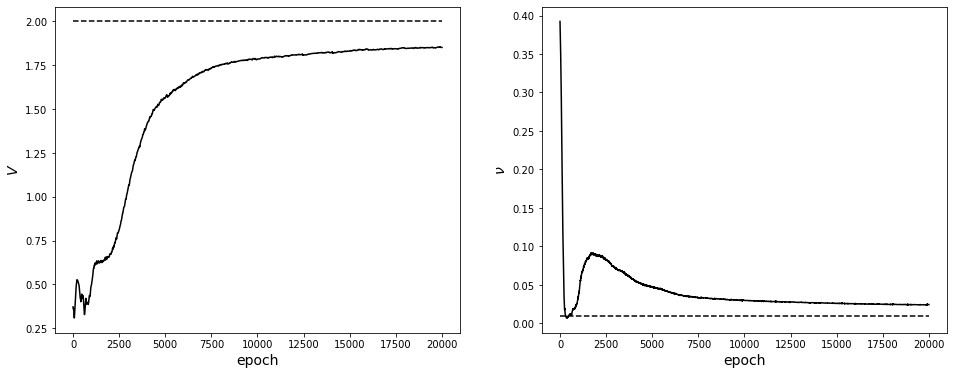

In [8]:
# plot learning history of V and nu
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(figsize=(16, 6), ncols=2)
ax1.plot(Vs0, '-k')
ax1.hlines(y=V0, xmin=0, xmax=max_epochs, linestyles='--', colors='k')
ax2.plot(nus0, '-k')
ax2.hlines(y=nu0, xmin=0, xmax=max_epochs, linestyles='--', colors='k')
ax1.set_ylabel(r'$V$', fontsize=14)
ax2.set_ylabel(r'$\nu$', fontsize=14)
for ax in [ax1, ax2]:
    ax.set_xlabel('epoch', fontsize=14)